### Data Simulation for EV Charging System

In order to find an optimal solution to the problem and evaluate system performance, data is a crucial component of this system simulation. The goal of data simulation is to generate a dataset that closely mirrors real-world data. This simulation aims to create 5 distinct tables out of the 7 available in the database. Not all tables were utilized in the algorithms, and some were specifically designed to simulate data intended for database loading, such as electricity pricing from the Grid and PV. The tables created for the algorithms include the user table, building electricity meter, and EV characteristics. The EV charger and User-charge-session tables were not simulated, as they are the outputs of the algorithms and represent system outputs.

Simulation requirements: Simulation requirements were derived from [3], some of the requirements was hardened to extreme conditions.
- Distribution transformer of building with 126 apartments or private houses supply 630 [KVA].
- The area of building is wealthy, and each family have 1.5, and total of Vehicles is 189.
- EVs Rate of EVs in building in phase of algorithms development should be 100% which it is 189 EVs
- EVs Rate of EVs in building in phase of algorithms evaluating performance should be 78%, based on adoption rate of EVs in sustainable development scenario, which it is a 148 EVs.
-
All EVs users need to charge their EVs in a timeframe of 24 hours.
The simulation process is divided into five steps, steps are described below:
User Data Simulation: This section of the script simulates data for EV users. It includes details such as the user ID, time of the charge request, and estimated driving distance (EDD). For each user, the script also determines the energy required for the next departure (ENonD) by considering the estimated driving distance and the EV's efficiency. This data is then stored in a data frame named 'df_user'.
EV Data Generation: This section of the script simulates data for various types of EVs, using a list of the 8 best-selling cars in Israel. For each EV, the script generates a random state of charge (SOC) and determines the energy required for the next departure (ENonD). This data is then stored in a data frame named 'df_ev_sampled'.
Electricity Price Simulation: This part of the script simulates the price of electricity from the grid for different months and hours of the day. It also assumes a fixed price for electricity from photovoltaic (PV) panels.
Building Electricity Meter Simulation: This section of the script simulates the solar power input, grid power input, and household electricity load for a building. It employs an irradiation dataset to determine the power output of the PV panels at various times throughout the day. The grid's

In [195]:
from pathlib import Path
from omegaconf import OmegaConf, DictConfig
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import gaussian_kde
import math
from datetime import datetime
import importlib

In [196]:
# Load simulation parameters and paths from the YAML config file
CONFIG_PATH = Path("../../config/simulation_params.yaml")
cfg = OmegaConf.load(CONFIG_PATH)
print(cfg)

{'simulation': {'N_ev': 2000, 'n_households': 126, 'edd_mu': 51, 'edd_sigma': 11, 'drive_distance_efficiency': 190, 'charge_rate': 11, 'low_soc': 0.15, 'high_soc': 0.5, 'photo_voltaic': {'pv_id': 1, 'electricity_price': 0.45, 'pv_area': 50, 'pv_efficiency': 0.2, 'Performance_Ratio': 0.75}, 'grid': {'max_power_allowed_transformer': 630, 'power_factor_transformer': 0.56}, 'electricity_price': {'hours': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'months': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 'table': [[15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 59.4, 59.4, 59.4, 59.4, 59.4, 15.8, 15.8], [15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 15.8, 59.4, 59.4, 59.4, 59.4, 59.4, 15.8, 15.8], [15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 15.2, 18.2, 1

In [197]:
cfg.data.paths.charge_data

'../../src/data/raw/fixed_Dataset 1_EV charging reports.csv'

# 1. User data Table Simulation

### 1.1.	User ID:

Create series of id for later to pick user number randomly without replacement, user identity is unique and is used to identify the user in the simulation.

In [198]:
# Create Series for user IDs
number_of_EVehicles = cfg.simulation.N_ev
Users_ID = pd.Series(np.arange(number_of_EVehicles))

### 1.2.	Time of request:
Time of request data represents the time of charge request -> Time of request should be aligned with the arrival time data
### 1.3 Arival and Departurte

Import charge dataset, apply preprocessing and find best distribution

In [199]:
cfg.data.paths.charge_data

'../../src/data/raw/fixed_Dataset 1_EV charging reports.csv'

In [200]:
df_chargeData = pd.read_csv(cfg.data.paths.charge_data)

prepare charge data

In [201]:
# Ensure you drop rows with missing values in BOTH columns, then .copy() to avoid SettingWithCopyWarning
df_charge = df_chargeData.dropna(subset=['Start_plugin', 'End_plugout']).copy()

# Convert columns to datetime; coerce errors to NaT so we can spot them if format is wrong
df_charge['Start_plugin'] = pd.to_datetime(df_charge['Start_plugin'], format="%d.%m.%Y %H:%M", errors='coerce')
df_charge['End_plugout'] = pd.to_datetime(df_charge['End_plugout'], format="%d.%m.%Y %H:%M", errors='coerce')

# Verify conversion worked
print(df_charge[['Start_plugin', 'End_plugout']].dtypes)
print(df_charge[['Start_plugin', 'End_plugout']].head())

# Now safely use .dt
df_charge['Start_plugin_day_type'] = df_charge['Start_plugin'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
df_charge['End_plugout_day_type'] = df_charge['End_plugout'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')


Start_plugin    datetime64[ns]
End_plugout     datetime64[ns]
dtype: object
         Start_plugin         End_plugout
0 2018-12-21 10:20:00 2018-12-21 10:23:00
1 2018-12-21 10:24:00 2018-12-21 10:32:00
2 2018-12-21 11:33:00 2018-12-21 19:46:00
3 2018-12-22 16:15:00 2018-12-23 16:40:00
4 2018-12-24 22:03:00 2018-12-24 23:02:00


In [202]:
# get data of plugin and plugout of weekday
data_Weekday_plugin = df_charge['Start_plugin'][df_charge['Start_plugin_day_type'] == 'Weekday']
data_Weekday_plugout = df_charge['End_plugout'][df_charge['End_plugout_day_type'] == 'Weekday']
# get data of plugin and plugout of weekend
data_Weekend_plugin = df_charge['Start_plugin'][df_charge['Start_plugin_day_type'] == 'Weekend']
data_Weekend_plugout = df_charge['End_plugout'][df_charge['End_plugout_day_type'] == 'Weekend']

# calculate time difference between plugin to plugout of weekdays and weekends for waiting time until departed
time_delta_weekday = (data_Weekday_plugout - data_Weekday_plugin).dt.total_seconds()/3600
time_delta_weekend = (data_Weekend_plugout - data_Weekend_plugin).dt.total_seconds()/3600

# in some cases charge time is larger than wait time -> the algorithm will not be able to solve those cases
# to prevent that issue 1 hour added to time delta
time_delta_weekday = time_delta_weekday + 1
time_delta_weekend = time_delta_weekend + 1

# Nan values found after time delta calculation
# drop nan values from time delta variables
time_delta_weekday = time_delta_weekday.dropna()
time_delta_weekend = time_delta_weekend.dropna()

### Arrival Weekday

*  KDE estimator used to find arrival distribution -> arrival assumed to be the same as plugin time

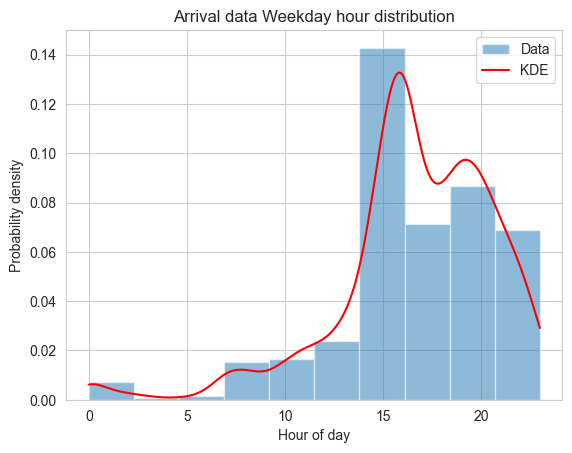

In [203]:
data_Weekday_hour = data_Weekday_plugin.dt.hour # convert time values to hours data for fitting
kde_data_Weekday_hour = gaussian_kde(data_Weekday_hour) # use kde function to find data distribution function
x = np.linspace(data_Weekday_hour.min(), data_Weekday_hour.max(), data_Weekday_hour.shape[0])
pdf_data_Weekday_hour = kde_data_Weekday_hour(x)
plt.hist(data_Weekday_hour, bins=10, density=True, alpha=0.5, label='Data')
plt.plot(x, pdf_data_Weekday_hour, 'r', label='KDE')
plt.title('Arrival data Weekday hour distribution')
plt.xlabel('Hour of day')
plt.ylabel('Probability density')
plt.legend()
plt.show()

### Arrival Weekend

*   KDE estimator used to find arrival distribution -> arrival assumed to be the same as plugin time

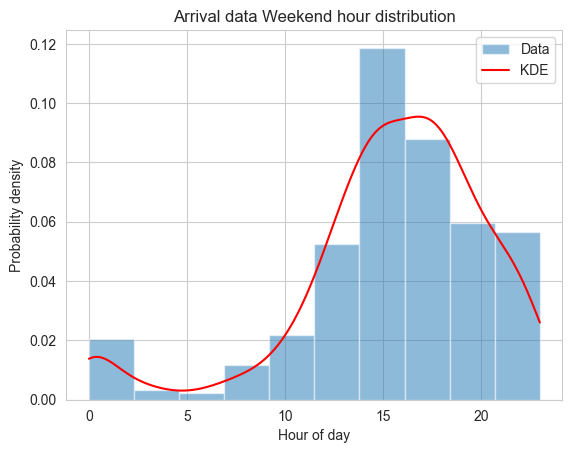

In [204]:
data_Weekend_hour = data_Weekend_plugin.dt.hour  # convert time values to hours data for fitting
kde_data_Weekend_hour = gaussian_kde(data_Weekend_hour)  # use kde function to find data distribution function
x = np.linspace(data_Weekend_hour.min(), data_Weekend_hour.max(), data_Weekend_hour.shape[0])
pdf_data_Weekend_hour = kde_data_Weekend_hour(x)

plt.hist(data_Weekend_hour, bins=10, density=True, alpha=0.5, label='Data')
plt.plot(x, pdf_data_Weekend_hour, 'r', label='KDE')

plt.title('Arrival data Weekend hour distribution')
plt.xlabel('Hour of day')
plt.ylabel('Probability density')
plt.legend()
plt.show()

### Wait time until departure


*    KDE estimator used to find best distributon for wait time for week days and weekends

Weekday

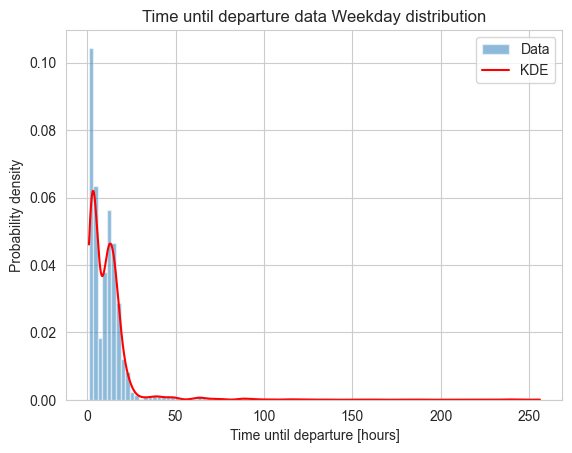

In [205]:
kde_time_delta_weekday = gaussian_kde(time_delta_weekday)
x = np.linspace(time_delta_weekday.min(), time_delta_weekday.max(), time_delta_weekday.shape[0])
pdf_time_delta_weekday = kde_time_delta_weekday(x)
plt.hist(time_delta_weekday, bins=100, density=True, alpha=0.5, label='Data')
plt.plot(x, pdf_time_delta_weekday, 'r', label='KDE')
plt.title('Time until departure data Weekday distribution')
plt.xlabel('Time until departure [hours]')
plt.ylabel('Probability density')
plt.legend()
plt.show()

Weekend

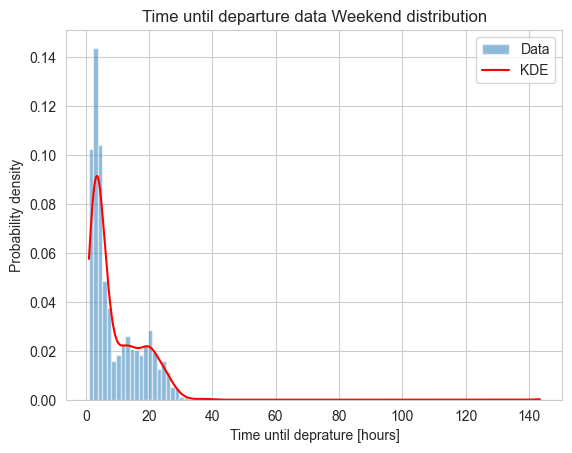

In [206]:
kde_time_delta_weekend = gaussian_kde(time_delta_weekend)
x = np.linspace(time_delta_weekend.min(), time_delta_weekend.max(), time_delta_weekend.shape[0])
pdf_time_delta_weekend = kde_time_delta_weekend(x)
plt.hist(time_delta_weekend, bins=100, density=True, alpha=0.5, label='Data')
plt.plot(x, pdf_time_delta_weekend, 'r', label='KDE')
plt.title('Time until departure data Weekend distribution')
plt.xlabel('Time until deprature [hours]')
plt.ylabel('Probability density')
plt.legend()
plt.show()

### 1.4.	Estimated Driving Distance (EDD)

In [207]:

EDD_dist = pd.Series(np.random.normal(cfg.simulation.edd_mu, cfg.simulation.edd_sigma, len(Users_ID)))

### 1.5.	Energy Needed on next Departure ENonD:

In [208]:
#Energy Needed on next Departure (ENonD):
def calc_ENonD(EDD_dist,EV_efficancy):
  ENunD = (EDD_dist * EV_efficancy) /1000 # convert to KW
  return pd.Series(ENunD)

In [209]:

def get_data_from_kde(kde_obj, N_samples):
    """function to sample data from KDE distributions"""
    arr = (kde_obj.resample(N_samples))
    arr = pd.Series(np.reshape(arr, arr.shape[1]))
    arr = arr.where(arr < 23.99, 23.99) # limit hour of day or wait time to 23.99 hour_of_day / hours
    arr = arr.where(arr >= 1, 1.5) # to prevent zero time between arrival to departure 1.5 hours added
    return arr

def get_departure_time(arrival_times,delta_times):
  """function to Convert float hour values to real hour values (int) and create DateTime objects"""
  datetime_objects = []
  time_now = datetime.now()
  for hour in arrival_times:
    hour, minute = divmod(hour * 60, 60)
    datetime_obj = time_now.replace(hour=int(hour), minute=int(minute))
    datetime_objects.append(datetime_obj)

  # Format the DateTime objects as "dd/mm/yy - hh:mm"
  formatted_dates = pd.Series([datetime_obj.strftime("%d/%m/%y - %H:%M") for datetime_obj in datetime_objects])
  formatted_dates = pd.to_datetime(formatted_dates)
  timedelta_series = pd.to_timedelta(delta_times, unit='h')
  departure_times =(formatted_dates + timedelta_series)
  return departure_times

def convert_float_time_to_datetime(float_time):
      # Convert float hour values to real hour values and create DateTime objects
  datetime_objects = []
  time_now = datetime.now()
  for hour in float_time:
    hour, minute = divmod(hour * 60, 60)
    datetime_obj = time_now.replace(hour=int(hour), minute=int(minute))
    datetime_objects.append(datetime_obj)

  # Format the DateTime objects as "dd/mm/yy - hh:mm"
  formatted_dates = pd.Series([datetime_obj.strftime("%d/%m/%y - %H:%M") for datetime_obj in datetime_objects])
  formatted_dates = pd.to_datetime(formatted_dates)
  return formatted_dates


In [210]:
# Get arrival and departure data to generate Users dataset
weekday_arrival = get_data_from_kde(kde_data_Weekday_hour, number_of_EVehicles)
weekday_departure = get_departure_time(weekday_arrival, get_data_from_kde(kde_time_delta_weekday, number_of_EVehicles))
weekday_arrival = convert_float_time_to_datetime(weekday_arrival)
df_user = pd.DataFrame(columns=['UID', 'Arrival_time', 'Departure_time', 'Estimated_Drive_Distance'])
df_user['UID'] = Users_ID
df_user['Arrival_time'] = weekday_arrival
df_user['Departure_time'] = weekday_departure
df_user['Estimated_Drive_Distance'] = EDD_dist
df_user['TuD (int)'] =((df_user['Departure_time'] - df_user['Arrival_time']).dt.total_seconds() / 3600)# / pd.Timedelta(minutes=1))/60

C:\Users\dtubiana\AppData\Local\Temp\ipykernel_32464\3710815776.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  formatted_dates = pd.to_datetime(formatted_dates)
C:\Users\dtubiana\AppData\Local\Temp\ipykernel_32464\3710815776.py:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  formatted_dates = pd.to_datetime(formatted_dates)


### check data validity

Text(0.5, 0, 'Hours until departure')

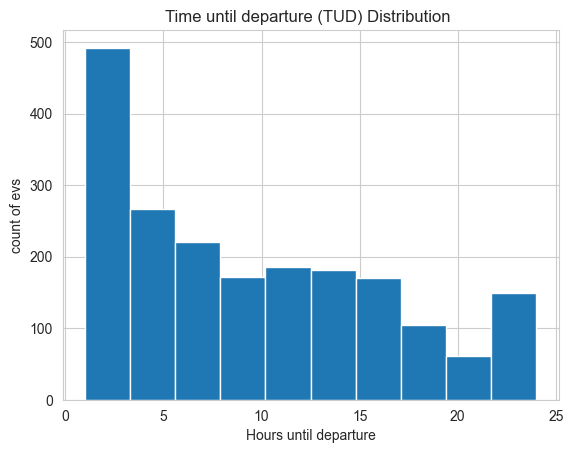

In [211]:
# time until departure distribution
plt.hist(df_user['TuD (int)'])
plt.title('Time until departure (TUD) Distribution ')
plt.ylabel('count of evs')
plt.xlabel('Hours until departure')

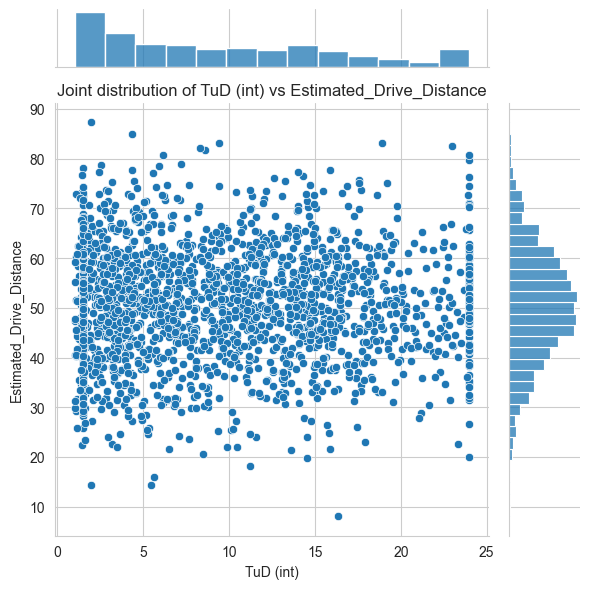

In [212]:
# Time until departure vs Estimated_Drive_Distance
sns.jointplot(data=df_user , x ='TuD (int)' , y= 'Estimated_Drive_Distance')
plt.title('Joint distribution of TuD (int) vs Estimated_Drive_Distance')
plt.tight_layout()

Text(0.5, 0, 'charge time [h]')

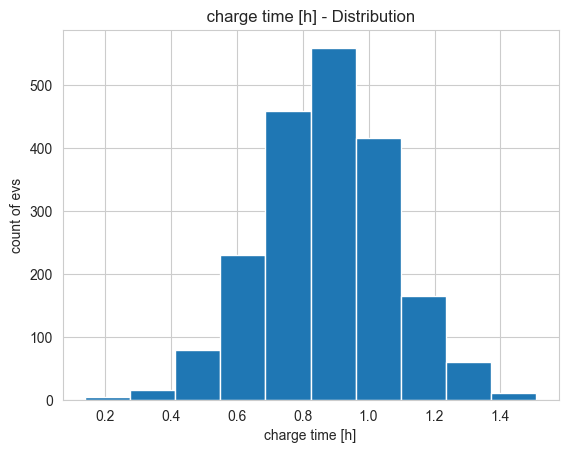

In [213]:
# charge time distribution : based on maximal ev efficiency which consumes maximal energy per km



df_user['charge_time'] = ((df_user['Estimated_Drive_Distance']*cfg.simulation.drive_distance_efficiency)/1000/ cfg.simulation.charge_rate) #
plt.hist(df_user['charge_time'])
plt.title(' charge time [h] - Distribution ')
plt.ylabel('count of evs')
plt.xlabel('charge time [h]')

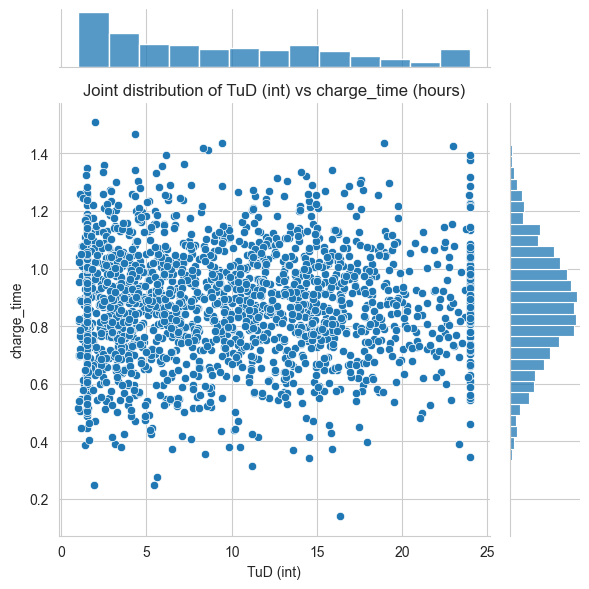

In [214]:

sns.jointplot(data=df_user , x ='TuD (int)' , y= 'charge_time')
plt.title('Joint distribution of TuD (int) vs charge_time (hours)')
plt.tight_layout()

In [215]:
# check if charge time is larger than time until departure
# if charge time is larger than time until departure, the algorithm will not be able to solve
# this case, so we filter out those cases
df_user = df_user[df_user['charge_time'] - df_user['TuD (int)'] < 0]

In [216]:
df_ev = pd.read_excel(cfg.data.paths.adopted_evsISR_path)
df_ev.head(5)

,Brand_Model,Range [Km],Efficiency [Wh/Km],Battery capacity [KWh],Max charge rate AC [Kw],Prob_to_buy,amount
0,Geely Geometry C,460,152,70.0,11,0.317555,6816
1,Tesla Model 3,405,142,57.5,11,0.216549,4648
2,BYD Atto 3,325,186,60.5,11,0.172568,3704
3,Hyundai Ioniq 5,295,183,54.0,11,0.083116,1784
4,aiways u5,315,190,60.0,11,0.061126,1312


In [217]:
df_ev_sampled = df_ev.sample(n=number_of_EVehicles, replace=True, weights=df_ev['Prob_to_buy']).reset_index(drop=True)
# drop non-relevant columns [Prob_to_buy, amount]
df_ev_sampled = df_ev_sampled.drop(columns=['Prob_to_buy', 'amount', 'Max charge rate AC [Kw]'])

In [218]:
EV_ID = Users_ID
df_ev_sampled = pd.concat([EV_ID,df_ev_sampled],axis=1) # set the same ID of users to evs to merge the datasets
df_ev_sampled  = df_ev_sampled.rename(columns={0: 'EV_Id'})

low_limit = cfg.simulation.low_soc
high_limit = cfg.simulation.high_soc

df_ev_sampled['SOC'] = np.random.uniform(low_limit, high_limit, len(df_ev_sampled)) # create soc based on uniform distribution
df_ev_sampled['ENonD'] = calc_ENonD(EDD_dist,df_ev_sampled['Efficiency [Wh/Km]']) # calculate energy needed on next departure based on ev efficacy

In [219]:
# show the first samples to evaluate dataframe
df_ev_sampled.head(10)

,EV_Id,Brand_Model,Range [Km],Efficiency [Wh/Km],Battery capacity [KWh],SOC,ENonD
0,0,Geely Geometry C,460,152,70.0,0.433358,6.785019
1,1,Tesla Model 3,405,142,57.5,0.357071,6.286080
2,2,Tesla Model Y,350,164,57.5,0.158368,7.903371
3,3,skoda enyaq,435,177,77.0,0.247691,10.268729
4,4,Tesla Model 3,405,142,57.5,0.164494,4.671293
5,5,aiways u5,315,190,60.0,0.177308,8.699705
6,6,Tesla Model 3,405,142,57.5,0.188709,7.589509
7,7,Geely Geometry C,460,152,70.0,0.269905,7.830631
8,8,Tesla Model 3,405,142,57.5,0.472866,7.399547
9,9,Geely Geometry C,460,152,70.0,0.404141,9.734985


In [220]:
# merge users data and evs data to one dataframe
usr_ev_data = pd.merge(df_user, df_ev_sampled, left_on='UID', right_on='EV_Id')
usr_ev_data.head(10)

,UID,Arrival_time,Departure_time,Estimated_Drive_Distance,TuD (int),charge_time,EV_Id,Brand_Model,Range [Km],Efficiency [Wh/Km],Battery capacity [KWh],SOC,ENonD
0,0,2025-07-28 17:23:00,2025-07-29 03:05:12.462187050,44.638280,9.703462,0.771025,0,Geely Geometry C,460,152,70.0,0.433358,6.785019
1,1,2025-07-28 17:34:00,2025-07-28 21:21:07.145480151,44.268170,3.785318,0.764632,1,Tesla Model 3,405,142,57.5,0.357071,6.286080
2,2,2025-07-28 14:33:00,2025-07-28 18:08:56.861020719,48.191285,3.599128,0.832395,2,Tesla Model Y,350,164,57.5,0.158368,7.903371
3,3,2025-07-28 20:22:00,2025-07-29 08:19:59.319408837,58.015416,11.966478,1.002084,3,skoda enyaq,435,177,77.0,0.247691,10.268729
4,4,2025-07-28 16:03:00,2025-07-29 03:20:24.943487481,32.896426,11.290262,0.568211,4,Tesla Model 3,405,142,57.5,0.164494,4.671293
5,5,2025-07-28 20:31:00,2025-07-29 15:27:51.082656964,45.787919,18.947523,0.790882,5,aiways u5,315,190,60.0,0.177308,8.699705
6,6,2025-07-28 19:58:00,2025-07-29 06:52:00.088598894,53.447247,10.900025,0.923180,6,Tesla Model 3,405,142,57.5,0.188709,7.589509
7,7,2025-07-28 18:57:00,2025-07-29 01:02:41.071698808,51.517308,6.094742,0.889844,7,Geely Geometry C,460,152,70.0,0.269905,7.830631
8,8,2025-07-28 23:01:00,2025-07-29 03:17:49.064515478,52.109488,4.280296,0.900073,8,Tesla Model 3,405,142,57.5,0.472866,7.399547
9,9,2025-07-28 21:14:00,2025-07-29 12:22:34.999274374,64.045953,15.143055,1.106248,9,Geely Geometry C,460,152,70.0,0.404141,9.734985


# 2. Electricity price from grid Table:

In [221]:


# Assume you have loaded cfg using OmegaConf.load or similar
price_cfg = cfg.simulation.electricity_price
months = price_cfg.months
hours = price_cfg.hours
table = price_cfg.table

# Convert to DataFrame, transpose if needed to match your structure
df_electricity_price = pd.DataFrame(table, columns=hours, index=months)
df_electricity_price = df_electricity_price.transpose() # if you want months as rows, hours as columns


In [222]:
df_electricity_price.head(3)  # Display the first 3 rows to check the data

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,15.8,15.8,15.2,15.2,15.2,18.6,18.6,18.6,18.6,15.2,15.2,15.8
1,15.8,15.8,15.2,15.2,15.2,18.6,18.6,18.6,18.6,15.2,15.2,15.8
2,15.8,15.8,15.2,15.2,15.2,18.6,18.6,18.6,18.6,15.2,15.2,15.8


# 3. Electricity price from photo_voltaic table:

In [223]:
pv_price_data = {'PV_id': [cfg.simulation.photo_voltaic.pv_id], 'electricity_price' : [cfg.simulation.photo_voltaic.electricity_price] }
pv_price = pd.DataFrame(data=pv_price_data)
pv_price

,PV_id,electricity_price
0,1,0.45


# 4. Building electricity meter

## 4.1 Solar power input

In [224]:
df_irradiation = pd.read_json(cfg.data.paths.irradiation_data_path)

In [225]:
# prepare irradiation data
# Convert date column to datetime object
df_irradiation['date'] =  pd.to_datetime(df_irradiation['date'])
# create hour column from data column
df_irradiation['hour'] = df_irradiation['date'].dt.hour
# Aggregate data by an hour and get mean radiation intensity for each hour
df_NIP_rad_hour = df_irradiation.groupby('hour').agg({'NIP': 'mean'})

In [226]:

def PV_power(hour_of_day : int , configPV : DictConfig ) -> float:
  pv_area = configPV.pv_area
  pv_efficiency = configPV.pv_efficiency
  performance_ratio = configPV.Performance_Ratio

  lower_hour = math.floor(hour_of_day)
  upper_hour = math.ceil(hour_of_day)
  rad_lower_hour = df_NIP_rad_hour.iloc[lower_hour]['NIP']
  rad_upper_hour = df_NIP_rad_hour.iloc[upper_hour]['NIP']
  x = [lower_hour,upper_hour]
  y = [rad_lower_hour, rad_upper_hour]
  rad_level = np.interp(hour_of_day, x, y)
  power = pv_area * pv_efficiency * performance_ratio * rad_level / 1000  # Convert to KW
  return power


power_output = []
for hour in range(0,24):
  power_output.append(PV_power(hour, cfg.simulation.photo_voltaic) )

df_power_output_pv = pd.DataFrame(data={'Hour_of_day': np.arange(0,24), "PV_pwr_output": np.array(power_output)})
df_power_output_pv

,Hour_of_day,PV_pwr_output
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
5,5,0.000000
6,6,0.335524
7,7,1.821573
8,8,3.099718
9,9,3.844194


In [227]:
## 4.2 Grid power Input

In [228]:
Max_power_allowed_transformer = cfg.simulation.grid.max_power_allowed_transformer
power_factor_transformer = cfg.simulation.grid.power_factor_transformer
Grid_max_power_input = Max_power_allowed_transformer * power_factor_transformer
power_input_grid = np.ones(24) * Grid_max_power_input
grid_pwr_data  = {"Hour_of_day" : np.arange(0,24), "PWR_input_grid[KW]": power_input_grid}
df_grid_pwr  = pd.DataFrame(data =grid_pwr_data)
df_grid_pwr

,Hour_of_day,PWR_input_grid[KW]
0,0,352.8
1,1,352.8
2,2,352.8
3,3,352.8
4,4,352.8
5,5,352.8
6,6,352.8
7,7,352.8
8,8,352.8
9,9,352.8


## 4.3 Household electricity load

In [229]:
df_houseload = pd.read_csv(cfg.data.paths.households_data_path)

In [230]:
# prepare household load data
df_houseload = df_houseload.dropna()
df_houseload['datetime'] = pd.to_datetime( df_houseload['datetime'])
df_houseload['hour'] = df_houseload['datetime'].dt.hour

df_houseload['Global_active_power[WH]'] = (df_houseload['Global_active_power']*1000 / 60) - (df_houseload['Sub_metering_1'] + df_houseload['Sub_metering_2'] + df_houseload['Sub_metering_3'])
df_houseload['Global_active_power[Kw]'] = df_houseload['Global_active_power[WH]']*60/1000 # hours/ kw

df_hour_grp = df_houseload.groupby('hour').agg({'Global_active_power[Kw]': 'mean'}).reset_index()

In [231]:
df_hour_grp['Global_active_power_N_households'] = df_hour_grp['Global_active_power[Kw]'] * cfg.simulation.n_households
hh_pwr_data  = {"Hour_of_day" : df_hour_grp['hour'], "PWR_consumption_out[KW]": df_hour_grp['Global_active_power_N_households']}
df_hh_pwr  = pd.DataFrame(data =hh_pwr_data)
df_hh_pwr

,Hour_of_day,PWR_consumption_out[KW]
0,0,53.707366
1,1,45.283642
2,2,41.483125
3,3,40.102271
4,4,38.933916
5,5,38.360048
6,6,64.884634
7,7,101.948301
8,8,70.390092
9,9,53.659988


# Building data To export

### Merge data from PV, household power, and grid power input

In [232]:
df_building = pd.merge(df_hh_pwr, df_grid_pwr, on='Hour_of_day').merge(df_power_output_pv, on='Hour_of_day')
# find surplus power by subtracting household power from grid power and pv power sum
df_building['surplus_power[kw]'] = df_building['PWR_input_grid[KW]'] + df_building['PV_pwr_output'] - df_building['PWR_consumption_out[KW]']
df_building.head(3)  # Display the first 3 rows to check the data

,Hour_of_day,PWR_consumption_out[KW],PWR_input_grid[KW],PV_pwr_output,surplus_power[kw]
0,0,53.707366,352.8,0.0,299.092634
1,1,45.283642,352.8,0.0,307.516358
2,2,41.483125,352.8,0.0,311.316875


# Data export:
1. users and evs dataset
2. Electricity price table
3. PV (solar panels) price tables
4. Building power data

In [233]:
# Load config (assumes you've already done OmegaConf.load)
output_dir = Path(cfg.data.paths.output_dir)

# Ensure the output directory exists
output_dir.mkdir(parents=True, exist_ok=True)

# Export DataFrames
usr_ev_data.to_excel(output_dir / cfg.data.paths.usr_ev_data)
df_electricity_price.to_excel(output_dir / cfg.data.paths.electricity_price)
pv_price.to_excel(output_dir / cfg.data.paths.pv_price)
df_building.to_excel(output_dir / cfg.data.paths.building_data)
